# Multivariate Linear Regression on CarDekho

The CarDekho dataset contains information about used cars listed on the website of the same name.<br/>
This dataset has 301 unique entities with the following features:
- car name
- year of release
- selling price
- present price
- kilometers driven
- fuel: such as petrol or diesel
- transmission: such as manual or automatic
- owner: how many times the car changed owner

The goal of this experiment is to train a linear model to predict the selling price of a car.<br/>
We will use the framework Pytorch for the matrix calculus.

In [2]:
import os
import sys
import torch
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

### Read data from csv using Pandas

In [3]:
df = pd.read_csv(os.path.join('data', 'car_data.csv'))
df.head()

Car_Name  Year  Selling_Price  Present_Price  Kms_Driven Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Seller_Type Transmission  Owner  
0      Dealer       Manual      0  
1      Dealer       Manual      0  
2      Dealer       Manual      0  
3      Dealer       Manual      0  
4      Dealer       Manual      0

### Convert categorical variable into indicator variables

In [4]:
f_continuous = df[['Year', 'Selling_Price', 'Present_Price', 'Kms_Driven', 'Owner']]
f_categorical = pd.get_dummies(df[['Fuel_Type', 'Seller_Type', 'Transmission']])
df = pd.concat([f_continuous, f_categorical], axis=1)

# Drop refundant features
df.drop(['Transmission_Automatic', 'Seller_Type_Dealer', 'Fuel_Type_CNG'], axis=1, inplace=True)
df.head()

Year  Selling_Price  Present_Price  Kms_Driven  Owner  Fuel_Type_Diesel  \
0  2014           3.35           5.59       27000      0                 0   
1  2013           4.75           9.54       43000      0                 1   
2  2017           7.25           9.85        6900      0                 0   
3  2011           2.85           4.15        5200      0                 0   
4  2014           4.60           6.87       42450      0                 1   

   Fuel_Type_Petrol  Seller_Type_Individual  Transmission_Manual  
0                 1                       0                    1  
1                 0                       0                    1  
2                 1                       0                    1  
3                 1                       0                    1  
4                 0                       0                    1

### Visualize histogram of all features

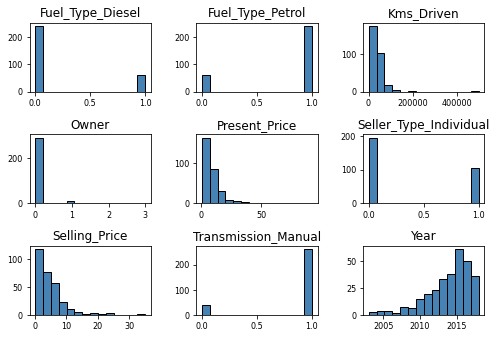

In [5]:
df.hist(bins=14, color='steelblue', edgecolor='black', linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout(rect=(0, 0, 1.2, 1.2))

Most cars on sales are consuming petrol instead of diesel, have had only one owner, are from 2012-present, are manual and have a selling price between 1000 and 10000 dollars.

### Heatmap correlation

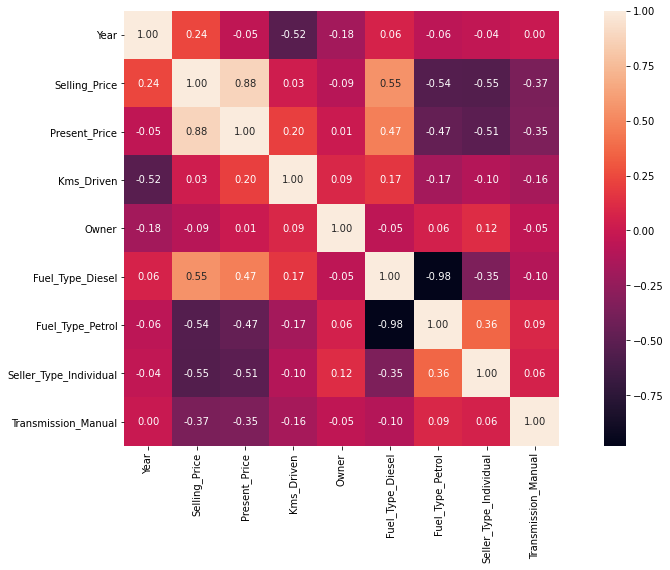

In [6]:
plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(), square= True, annot=True, fmt='.2f')

Most of the variables are highly correlated.<br/>
As expected, the present price variable is the most correlated with the target selling price.

### Pairwise Plots

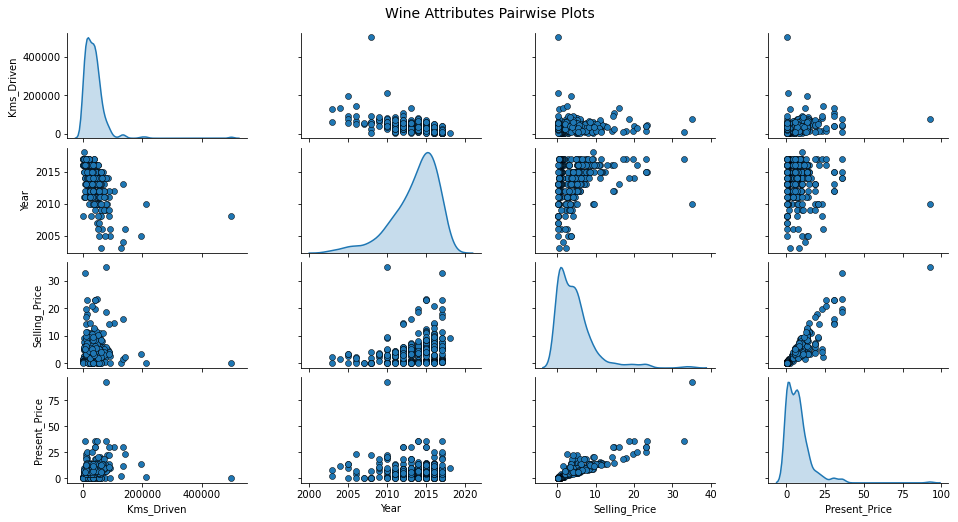

In [7]:
cols_viz = ['Kms_Driven', 'Year', 'Selling_Price', 'Present_Price']
pp = sns.pairplot(df[cols_viz], height=1.8, aspect=1.8,
                  plot_kws=dict(edgecolor="k", linewidth=0.5),
                  diag_kind="kde", diag_kws=dict(shade=True))

fig = pp.fig 
fig.subplots_adjust(top=0.93, wspace=0.3)
t = fig.suptitle('Wine Attributes Pairwise Plots', fontsize=14)

Most of the features are highly correlated to each other.<br/>
Some outliers are present but as there is very few, we will keep them in the training set.<br>
The year feature have a polynomial correlation with the selling price.<br>
A polynomial regression will most likely overperform a linear regression.

### Make train test split

In [8]:
# Separate the target from the dataFrame
Y = df['Selling_Price']
X = df.drop('Selling_Price', axis=1)

In [9]:
# Convert data to Pytorch tensor
X_t = torch.from_numpy(X.to_numpy()).float()
Y_t = torch.from_numpy(Y.to_numpy()).float().unsqueeze(1)
X_train, X_test, Y_train, Y_test = train_test_split(X_t, Y_t, test_size=0.33, random_state=42)

### Train a multivariate linear regression
Training a linear model using least square regression is equivalent to minimize the mean squared error:

$$
\begin{align}
    \large \text{Mse}(\boldsymbol{\hat{y}}, \boldsymbol{y}) &= \frac{1}{n}\sum_{i=1}^{n}{||\hat{y}_i - y_i ||_{2}^{2}} \\
    &= \frac{1}{n}||\boldsymbol{X}\boldsymbol{w} - \boldsymbol{y} ||_2^2
\end{align}
$$

where $n$ is the number of samples, $\hat{y}$ is the predicted value of the model and $y$ is the true target.<br/>
The prediction $\hat{y}$ is obtained by matrix multiplication between the input $\boldsymbol{X}$ and the weights of the model $\boldsymbol{w}$.<br/>

Minimizing the $\text{Mse}$ can be achieved by solving the gradient of this equation equals to zero in regards to the weights $\boldsymbol{w}$:

$$
\begin{align}
    \large \nabla_{\boldsymbol{w}}\text{Mse} &= 0 \\
    \large (\boldsymbol{X}^\top \boldsymbol{X})^{-1}\boldsymbol{X}^\top \boldsymbol{y} &= \boldsymbol{w}
\end{align}
$$

For more information on how to find $\boldsymbol{w}$ please visit the following [link](https://en.wikipedia.org/wiki/Least_squares#Linear_least_squares:~:text=A%20regression%20model%20is%20a%20linear%20one%20when%20the%20model%20comprises%20a%20linear%20combination%20of%20the%20parameters).

In [11]:
def add_ones_col(X):
    """Add a column a one to the input torch tensor"""
    x_0 = torch.ones((X.shape[0],), dtype=torch.float32).unsqueeze(1)
    X = torch.cat([x_0, X], dim=1)
    return X

def multi_linear_reg(X, y):
    """Multivariate linear regression function
    
    Args:
        X: A torch tensor for the data.
        y: A torch tensor for the labels.
    """
    X = add_ones_col(X)  # Add a column of ones to X to agregate the bias to the input matrices
    Xt_X = X.T.mm(X)
    Xt_y = X.T.mm(y)

    Xt_X_inv = Xt_X.inverse()
    w = Xt_X_inv.mm(Xt_y)
    return w

def prediction(X, w):
    """Predicts a selling price for each input
    
    Args:
        X: A torch tensor for the data.
        w: A torch tensor for the weights of the linear regression mode.
    """
    X = add_ones_col(X)
    return X.mm(w)

In [12]:
# Fit the training set into the model to get the weights
w = multi_linear_reg(X_train, Y_train)

# Predict using matrix multiplication with the weights
Y_pred_train = prediction(X_train, w)
Y_pred_test = prediction(X_test, w)

### Compute prediction error

In [13]:
def mse(Y_true, Y_pred):
    error = Y_pred - Y_true
    return (error.T.mm(error) / Y_pred.shape[0]).item()

def mae(Y_true, Y_pred):
    error = Y_pred - Y_true
    return error.abs().mean().item()

In [14]:
mse_train = mse(Y_train, Y_pred_train)
mae_train = mae(Y_train, Y_pred_train)
print('MSE Train:\t', mse_train)
print('MAE Train:\t', mae_train, end='\n\n')

mse_test = mse(Y_test, Y_pred_test)
mae_test = mae(Y_test, Y_pred_test)
print('MSE Test:\t', mse_test)
print('MAE Test:\t', mae_test, end='\n\n')

MSE Train:	 2.808985471725464
MAE Train:	 1.1321566104888916

MSE Test:	 3.7205495834350586
MAE Test:	 1.2941011190414429



The model has an error of 1.29 on average on the training test.<br/>
Not bad for a linear model, taking into consideration that the mean of the present price is 7.62.

### Principal component analysis visualization
In this section, we will use PCA to reduce the number of feature to two, in order to visualize the plane of the linear regressor.

In [15]:
def cov(X):
    """Computes the covariance of the input
    
        The covariance  matrix gives some sense of how much two values are
        linearly related to each other, as well as the scale of these variables.
        It is computed by (1 / (N - 1)) * (X - E[X]).T (X - E[X]).
    
    Args:
        X: A torch tensor as input.
    """
    X -= X.mean(dim=0, keepdim=True)
    fact = 1.0 / (X.shape[0] - 1)
    cov = fact * X.T.mm(X)
    return cov

def pca(X, target_dim=2):
    """Computes the n^th first principal components of the input
    
    PCA can be implemented using the n^th principal components of the covariance matrix.
    We could have been using an eigen decomposition because the covariance matrix is always squared
    but singular value decomposition does also the trick if we take the right singular vectors
    and perform a matrix multiplication to the right.
    
    Args:
        X: A torch tensor as the input.
        target_dim: An integer for selecting the n^th first components.
    """
    cov_x = cov(X)
    
    U, S, V = torch.svd(cov_x)
    transform_mat = V[:, :target_dim]
    X_reduced = X.mm(transform_mat)
    return X_reduced, transform_mat

In [16]:
X_test_pca, _ = pca(X_test, target_dim=2)
X_train_pca, _ = pca(X_train, target_dim=2)

In [34]:
points = torch.cat([X_test_pca[:3], Y_pred_test[:3]], axis=1)
v1 = points[2, :] - points[0, :]
v2 = points[1, :] - points[0, :]
cp = torch.cross(v1, v2)
a, b, c = cp
d = cp.dot(points[2, :])

min_mesh_x = min(X_test_pca[:, 0].min(), X_train_pca[:, 0].min())
max_mesh_x = max(X_test_pca[:, 0].max(), X_train_pca[:, 0].max())
min_mesh_y = min(X_test_pca[:, 1].min(), X_train_pca[:, 1].min())
max_mesh_y = max(X_test_pca[:, 1].max(), X_train_pca[:, 1].max())

mesh_x = np.linspace(min_mesh_x, max_mesh_x, 25)
mesh_y = np.linspace(min_mesh_y, max_mesh_y, 25)
mesh_xx, mesh_yy = np.meshgrid(mesh_x, mesh_y)

mesh_zz = (d - a * mesh_xx - b * mesh_yy) / c

Here we recreate the prediction plane using three points of the prediction.<br/>
More information at this [link](http://kitchingroup.cheme.cmu.edu/blog/2015/01/18/Equation-of-a-plane-through-three-points).

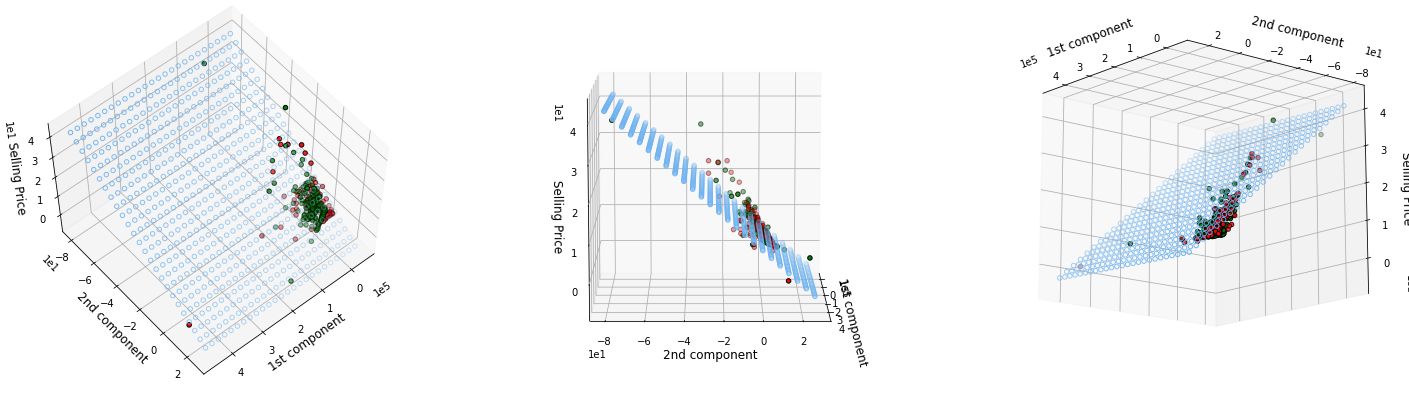

In [35]:
fig = plt.figure(figsize=(25,7))
ax1 = fig.add_subplot(131, projection='3d')
ax2 = fig.add_subplot(132, projection='3d')
ax3 = fig.add_subplot(133, projection='3d')
axes = [ax1, ax2, ax3]

for ax in axes:
    ax.scatter(X_test_pca[:, 0], X_test_pca[:, 1], Y_test, color='red', edgecolor='black')
    ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], Y_train, color='green', edgecolor='black')
    ax.scatter(mesh_xx.flatten(), mesh_yy.flatten(), mesh_zz.flatten(), facecolor=(0, 0, 0, 0), s=20, edgecolor='#70b3f0')
    
    ax.set_xlabel('1st component', fontsize=12)
    ax.set_ylabel('2nd component', fontsize=12)
    ax.set_zlabel('Selling Price', fontsize=12)
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
    ax.ticklabel_format(axis="z", style="sci", scilimits=(0,0))
ax1.view_init(elev=60, azim=50)
ax2.view_init(elev=10, azim=0)
ax3.view_init(elev=-15, azim=140)

The plane is fitting pretty well the data !

### Exploratory Data Analysis
We made an attempt to discard some features based on p-value but it didn't improve the results.<br/>
More on p-value [here](https://www.statsdirect.com/help/basics/p_values.htm#:~:text=The%20P%20value%2C%20or%20calculated,the%20hypothesis%20is%20being%20tested).

In [36]:
columns = X.columns
while len(columns) > 0:
    pvalues = []
    X_1 = X[columns]
    X_1 = sm.add_constant(X)  # add a columns of ones for the bias
    model = sm.OLS(Y, X_1).fit()  # fit a linear regression
    pvalues = pd.Series(model.pvalues[1:], index=columns)
    max_idx = np.argmax(pvalues)
    max_pval = pvalues[max_idx]
    if max_pval > 0.05:
        # if the p_values is greater than 0.05, the feature has not enough
        # informational value for the training
        columns = columns.drop(columns[max_idx]) 
        print('Dropping column ' + columns[max_idx] + ', pvalue is: ' + str(max_pval))
    else:
        break

Dropping column Seller_Type_Individual, pvalue is: 0.6296373292654155
Dropping column Fuel_Type_Diesel, pvalue is: 0.11176717429491591
Dropping column Seller_Type_Individual, pvalue is: 0.05428653381413104


In [37]:
# Keeping only the columns with very low p-value
X = df[columns]

X_t = torch.from_numpy(X.to_numpy()).float()
X_train, X_test, Y_train, Y_test = train_test_split(X_t, Y_t, test_size=0.33, random_state=42)

w = multi_linear_reg(X_train, Y_train)

Y_pred_train = prediction(X_train, w)
Y_pred_test = prediction(X_test, w)

mse_train = mse(Y_train, Y_pred_train)
mse_test = mse(Y_test, Y_pred_test)
print('MSE Train:\t', mse_train)
print('MSE Test:\t', mse_test)

MSE Train:	 3.4574925899505615
MSE Test:	 3.8332533836364746


### Conclusion

A linear regression can perform pretty well if the data is highly correlated.<br>
It is an appropriate method as a baseline in the majority of the regression tasks.<br>
The pvalue is not always a good indicator for feature selection.